# Visualising parsing of workflows 

In [28]:
import sys
import os
import json
import matplotlib.pyplot as plt
import igraph
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
from pubmetric.workflow import *



In [70]:
metadata_filename = os.path.join("../tests/data", "tool_metadata_test20_topic_0121_20250705.json")


## Documented workflows

In [38]:
cwl_filename = os.path.join("../tests/data", "candidate_workflow_test.cwl")

#TODO: would like to have a figure to compare to, does that work in APE now? 
with open(cwl_filename, 'r') as f:
    print(f.readlines()[6])

expected_tuple_workflow = [('14976030','14632076' )  , ('14976030','12403597')  , ('14632076','29400476')  , ('12403597', '29400476')  ]
                        # [ (XTandem, ProteinProphet), (XTandem, PeptideProphet), (ProteinProphet, StPeter), (PeptideProphet, StPeter) ]

tuple_workflow = parse_workflows(cwl_filename=cwl_filename, metadata_filename=metadata_filename)
print(sorted(tuple_workflow))
print(sorted(expected_tuple_workflow))

doc: A workflow including the tool(s) XTandem, ProteinProphet, PeptideProphet, StPeter.

[('12403597', '29400476'), ('14632076', '29400476'), ('14976030', '12403597'), ('14976030', '14632076')]
[('12403597', '29400476'), ('14632076', '29400476'), ('14976030', '12403597'), ('14976030', '14632076')]


In [41]:
workflow_tools = np.unique([element for tuple in tuple_workflow for element in tuple])
print(workflow_tools)

['12403597' '14632076' '14976030' '29400476']


To confirm that the workflow looks correct we plot it

In [ ]:
workflow_graph = igraph.Graph.TupleList(tuple_workflow, directed=True)

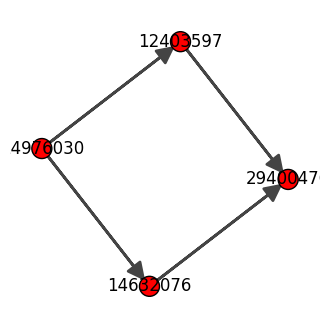

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
igraph.plot(
    workflow_graph,
    target=ax,  
    vertex_label=workflow_graph.vs["name"],
    vertex_size=20,
    bbox=(200, 200),
    margin=50
)
plt.show()

## Random workflows

We want the random workflows to have the same structure as the ones they are based on

In [42]:
with open(metadata_filename, 'r') as f:
    metadata_file = json.load(f)

In [44]:
included_tools = [tool['pmid'] for tool in metadata_file['tools']]
print(included_tools)

['38745111', '38110863', '23051804', '23051804', '23148064', '38681522', '38703894', '38658834', '38498849', '38233783', '38552327', '38517698', '38566187', '37328457', '38567734', '38711578', '38711760', '24909410', '25631240', '14632076', '12403597', '14976030', '29400476']


In [51]:
random_workflow = generate_random_workflow(included_tools, tuple_workflow)
print(random_workflow)

[('38745111', '38498849'), ('25631240', '38110863'), ('38498849', '38110863'), ('38745111', '25631240')]


To confirm that the random workflow looks correct we plot it

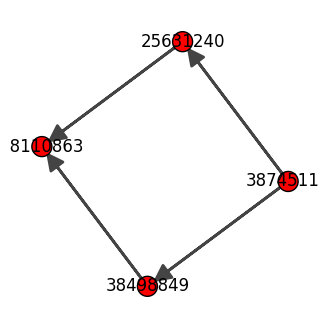

In [54]:
random_workflow_graph = igraph.Graph.TupleList(random_workflow, directed=True)
fig, ax = plt.subplots(figsize=(4, 4))
igraph.plot(
    random_workflow_graph,
    target=ax,  
    vertex_label=random_workflow_graph.vs["name"],
    vertex_size=20,
    bbox=(200, 200),
    margin=50
)
plt.show()

## Undocumented workflows

### Reconnecting edges in a workflow in case they are not present


Let's check what happens if PeptideProphet is removed 

In [139]:
name_workflow = [ ('XTandem', 'ProteinProphet'), ('XTandem', 'PeptideProphet'), ('ProteinProphet', 'StPeter'), ('PeptideProphet', 'StPeter') ]
reconnected_workflow = generate_pmid_edges(metadata_filename, name_workflow)
print(reconnected_workflow)

[('14976030', '14632076'), ('14976030', '12403597'), ('14632076', '29400476'), ('12403597', '29400476')]


In [155]:
faulty_name_workflow = [ ('XTandem', 'ProteinProphet'), ('XTandem', 'NotATOOL'), ('ProteinProphet', 'StPeter'), ('NotATOOL', 'StPeter') ]

reconnected_faulty_workflow = generate_pmid_edges(metadata_filename, faulty_name_workflow, handle_missing='reconnect')
removed_faulty_workflow = generate_pmid_edges(metadata_filename, faulty_name_workflow, handle_missing='remove')
kept_faulty_workflow = generate_pmid_edges(metadata_filename, faulty_name_workflow, handle_missing='keep')
print(reconnected_faulty_workflow)

['NotATOOL'] do(es) not have a pmid(s) and all edges to or from the node(s) will be excluded or reconnected.
['NotATOOL'] do(es) not have a pmid(s) and all edges to or from the node(s) will be excluded or reconnected.
[('14976030', '14632076'), ('14632076', '29400476'), ('14976030', '29400476')]


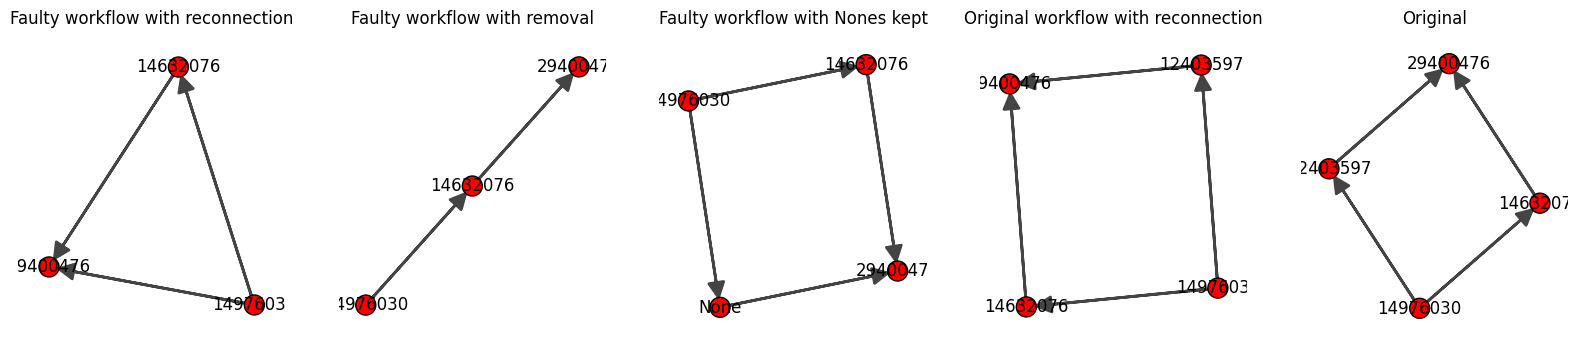

In [156]:
original_workflow_graph = igraph.Graph.TupleList(tuple_workflow, directed=True)
reconnected_workflow_graph = igraph.Graph.TupleList(reconnected_workflow, directed=True) # original run through reconnection should be the same

rec_faulty_workflow_graph = igraph.Graph.TupleList(reconnected_faulty_workflow, directed=True)
rm_faulty_workflow_graph = igraph.Graph.TupleList(removed_faulty_workflow, directed=True)
keep_faulty_workflow_graph = igraph.Graph.TupleList(kept_faulty_workflow, directed=True)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4)) 

igraph.plot(
    rec_faulty_workflow_graph,
    target=ax1,
    vertex_label=rec_faulty_workflow_graph.vs["name"] if "name" in rec_faulty_workflow_graph.vs.attributes() else None,
    vertex_size=20,
    bbox=(200, 200),
    margin=50
)
ax1.set_title('Faulty workflow with reconnection')

igraph.plot(
    rm_faulty_workflow_graph,
    target=ax2,
    vertex_label=rm_faulty_workflow_graph.vs["name"] if "name" in rm_faulty_workflow_graph.vs.attributes() else None,
    vertex_size=20,
    bbox=(200, 200),
    margin=50
)
ax2.set_title('Faulty workflow with removal')

igraph.plot(
    keep_faulty_workflow_graph,
    target=ax3,
    vertex_label=keep_faulty_workflow_graph.vs["name"] if "name" in keep_faulty_workflow_graph.vs.attributes() else None,
    vertex_size=20,
    bbox=(200, 200),
    margin=50
)
ax3.set_title('Faulty workflow with Nones kept')


igraph.plot(
    reconnected_workflow_graph,
    target=ax4,
    vertex_label=reconnected_workflow_graph.vs["name"] if "name" in reconnected_workflow_graph.vs.attributes() else None,
    vertex_size=20,
    bbox=(200, 200),
    margin=50
)
ax4.set_title('Original workflow with reconnection')

igraph.plot(
    original_workflow_graph,
    target=ax5,
    vertex_label=original_workflow_graph.vs["name"] if "name" in original_workflow_graph.vs.attributes() else None,
    vertex_size=20,
    bbox=(200, 200),
    margin=50
)
ax5.set_title('Original')

plt.show()